## Step 0. Module import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout  # Dense, Dropout 레이어 임포트
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 1. Data import

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## Step 2. Model design (ResNET 50)

In [4]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기의 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용
)

x = base_model.output
preds = Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [5]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Step 3. Normalizing and resizing

In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


75


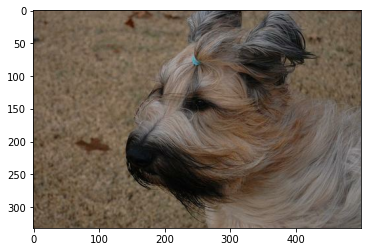

In [8]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## Step 4. Model compile

In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 171s 218ms/step - loss: 2.2633 - accuracy: 0.4305 - val_loss: 3.2990 - val_accuracy: 0.2192
Epoch 2/20
750/750 [==============================] - 167s 222ms/step - loss: 0.7447 - accuracy: 0.7963 - val_loss: 1.1884 - val_accuracy: 0.6556
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2063 - accuracy: 0.9632 - val_loss: 1.0381 - val_accuracy: 0.6981
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0615 - accuracy: 0.9961 - val_loss: 0.9903 - val_accuracy: 0.7222
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0328 - accuracy: 0.9984 - val_loss: 0.9619 - val_accuracy: 0.7295
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0183 - accuracy: 0.9995 - val_loss: 0.9609 - val_accuracy: 0.7325
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0122 - accuracy: 0.9997 - val_loss: 0.9522 -

## Training visualization

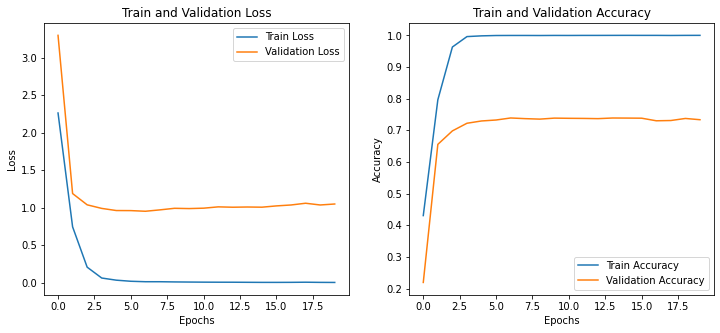

In [11]:
# 학습 과정의 정보를 이용하여 그래프를 그리는 함수
def plot_loss_accuracy(history):
    # 학습 및 검증 Loss 그래프
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 표시
    plt.show()

# Loss 및 Accuracy 그래프 그리기
plot_loss_accuracy(history_cam_model)

## 모델 학습 결과

* ### 먼저 Epoch 20에 LR 0.1로 학습을 시켜봤는데 train_acc가 1에 도달해서 이를 낮추고자 dropout을 0.5 넣고 비교해봄
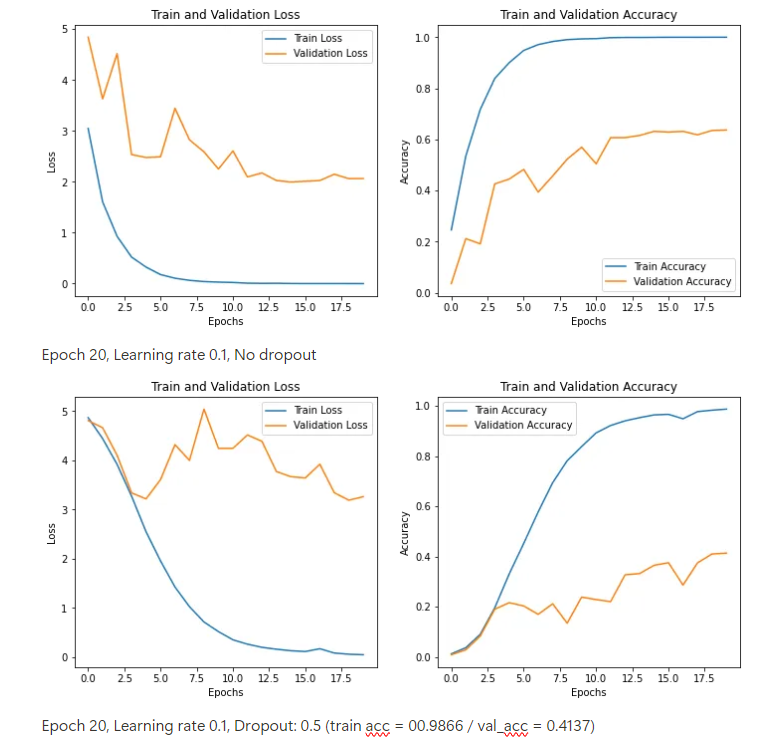

* ### dropout을 넣으면 너무 요상해져서 dropout을 넣지 않기로 결정하고 Learning rate를 좀 낮춰봄 0.05로
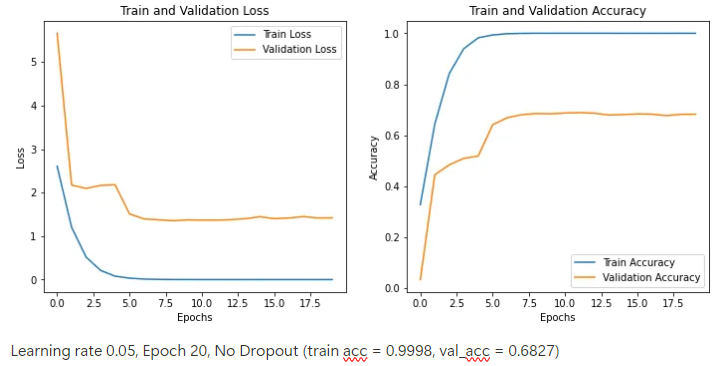

* ### 다른 그루분들이 그냥 0.01로 LR을 설정하는게 성능이 가장 좋았다고 하여 Learning rate 0.01, Epoch 20으로 학습함 (위에 나온 결과와 같음)
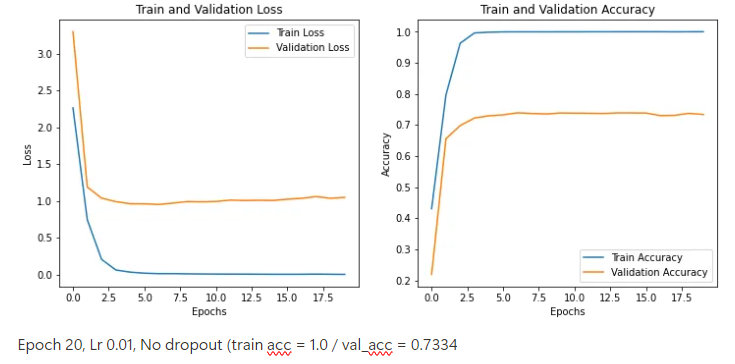

## Model save

In [12]:
cam_model_path = '/aiffel/class_activation_map/cam_model2.h5'

# 경로가 없으면 새로 만듭니다.
os.makedirs(os.path.dirname(cam_model_path), exist_ok=True)

# 모델 가중치 저장
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
cam_model = tf.keras.models.load_model(cam_model_path)

## Step 5. Design the CAM and G-CAM

In [14]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

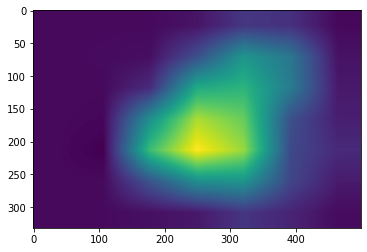

In [15]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [16]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

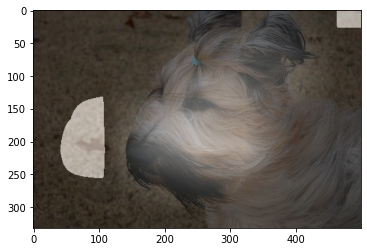

In [17]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [18]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

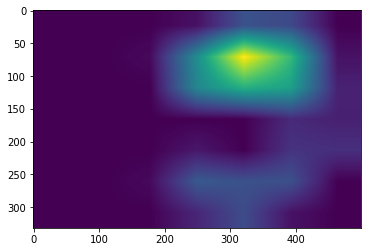

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 예시 이미지와 해당되는 CAM, G-CAM 비교 및 원본 이미지에 겹쳐본 결과

75


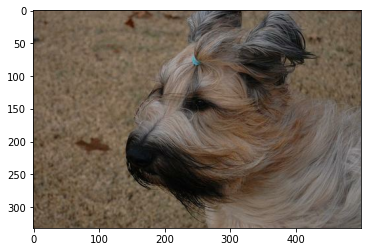

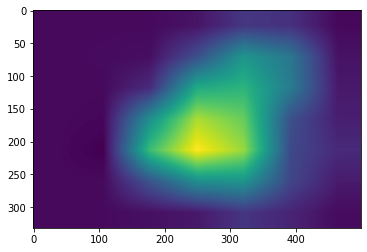

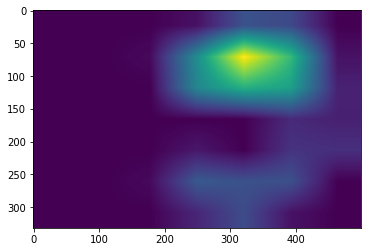

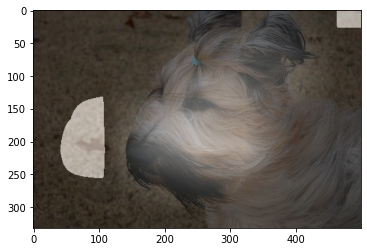

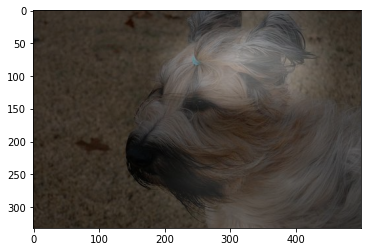

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

gcam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
plt.imshow(gcam_image)
plt.show()

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
gcam_image_3channel = np.stack([gcam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
blended_gimage = visualize_cam_on_image(gcam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

plt.imshow(blended_gimage)
plt.show()

## Bounding box 정의 및 CAM vs G-CAM 비교

In [26]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [28]:
grect = get_bbox(gcam_image)
grect

array([[183,   0],
       [499,   0],
       [499, 331],
       [183, 331]])

In [29]:
rect = get_bbox(cam_image)
rect

array([[115,   0],
       [499,   0],
       [499, 331],
       [115, 331]])

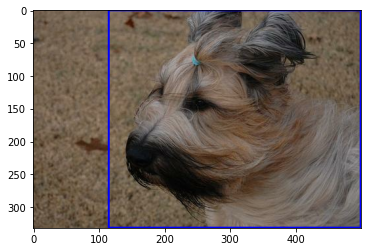

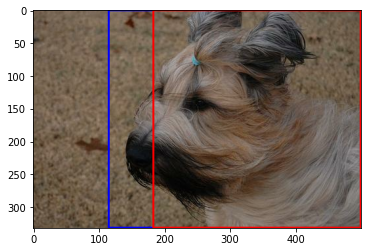

In [31]:
image = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image1)
plt.show()

image2 = cv2.drawContours(image, [grect], 0, (255,0,0), 2)
plt.imshow(image2)
plt.show()

## IOU 계산을 위한 계산 식 정리 및 비교

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
pred_bbox1 = rect_to_minmax(rect, item['image'])
pred_bbox1

[0.0, 0.23, 0.9969879518072289, 0.998]

In [36]:
pred_bbox2 = rect_to_minmax(grect, item['image'])
pred_bbox2

[0.0, 0.366, 0.9969879518072289, 0.998]

In [37]:
item['objects']['bbox']

array([[0.        , 0.28      , 0.99698794, 0.998     ]], dtype=float32)

In [38]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [39]:
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.9348957218524145

In [40]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.8802227341411648

## 회고

* ### ResNet50 + GAP + DenseLayer가 결합된 CAM 모델의 학습과정에서 수렴하는 방법이 살짝 어려웠다. Train accuracy가 너무 빨리 1.0에 도달해서 이것을 줄이기 위해 Drop out과 Learning rate를 조절해보았지만, 사실상 좋은 결과를 얻기 어려웠다.

* ### 어제 퍼실님과의 대화에서 빠르게 과적합을 만들기 위해 Learning rate를 크게 잡아보는 것이 좋다고 하여 0.01, 0.05, 0.1로 실험해보았지만, 이상하게도 0.01이 더 빠르게 수렴에 가까워진 것 같았다.

* ### 여기서 궁금한 것은, 만약 최종 모델의 결과와 같이 Train_acc가 1에 도달하였을 때에도 epoch을 왕창 늘리면 val_acc 또한 증가하고 과적합 되는 지점까지 볼 수 있을까?

* ### 퍼실님 답변: Scale 을 줄여서 확인해보면 이미 과적합이 일어난것으로 보인다.

* ### 이후 CAM과 Grad-CAM을 그려서 확인해보았다.

* ### 이유는 잘 모르겠지만, CAM을 사용한 것이 Grad-CAM 대비 IoU 계산 결과 더 높은 수치를 보였다.

* ### 현상적으로만 보았을 때에는 CAM이 좀 더 포괄적으로 강아지를 인식한 것 같고, Grad-CAM은 좀 더 국부적인 부분을 보고 강아지로 판단한 것 같다는 것이다.

* ### 그래서 그런지 CAM의 Bounding box가 좀 더 크다.

* ### 그런데 사실 Bounding box를 그리는 부분의 Threshold를 조절하면 크기가 달라질 수 있으므로 정확한 정답인지는 모르겠다.